In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2024-03-01  202.639999  204.520004  198.500000  200.520004   82099200
2024-03-04  188.139999  199.750000  186.720001  198.729996  134334900
2024-03-05  180.740005  184.589996  177.570007  183.050003  119660800
2024-03-06  176.539993  181.580002  173.699997  179.990005  107920900
2024-03-07  178.649994  180.039993  173.699997  174.350006  102129000


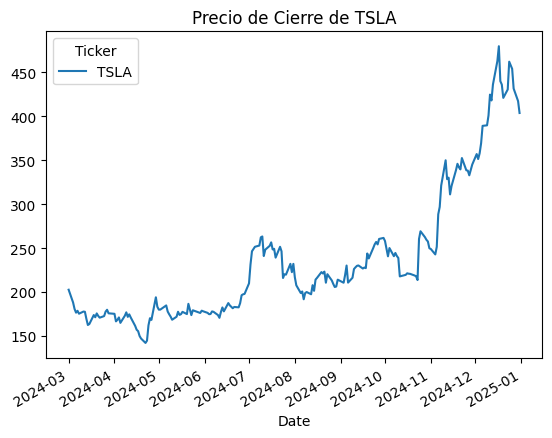

In [16]:
# 1. Especificar el ticker de la acción
ticker = 'TSLA'  # Aquí puedes poner el ticker que desees, por ejemplo, META  para Apple

# 2. Descargar los precios históricos usando yfinance
data = yf.download(ticker, start="2024-03-01", end="2025-01-01")  # Especificamos el rango de fechas

# 3. Visualizar los primeros registros
print(data.head())

# 4. Opcional: Graficar los precios de cierre
import matplotlib.pyplot as plt

data['Close'].plot(title=f"Precio de Cierre de {ticker}")
plt.show()

In [17]:
#Vemos la estructura de los datos
data[data.index>'2024-03-01'].head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2024-03-04,188.139999,199.750000,186.720001,198.729996,134334900
2024-03-05,180.740005,184.589996,177.570007,183.050003,119660800
2024-03-06,176.539993,181.580002,173.699997,179.990005,107920900
2024-03-07,178.649994,180.039993,173.699997,174.350006,102129000
2024-03-08,175.339996,182.729996,174.699997,181.500000,85315300


1. Vamos a emplear para el analisis los precios ajustados al cierre.
Estos precios son mas realistas, pues consideran la reparticion de dividendos, splits, consolidaciones comporativas etc

# Definicion del Movimiento Browniano Geometrico

Se ha demostrado matematicamente que el comportamiento de las acciones se puede modelar con un MBG.

$$dS(t) = \mu S(t) dt + \sigma S(t) dB(t)$$

donde:
- $S(t)$ es el precio en el tiempo $t$,
- $\mu$ es la tasa de crecimiento esperada,
- $\sigma$ es la volatilidad,
- $B(t)$ es un proceso de Wiener, tambien conocido como ruido aleatorio.

La solución de esta ecuación es:

$$S(t+1) = S(t) \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma B(t)\right)$$



1. Para calcular $\mu$ en primer lugar debemos calcular los retornos logaritmicos para cada momento $t$

$$rt=ln\left(\frac{st}{st-1}\right)$$

In [18]:
data['retornos']=(data['Close'] / data['Close'].shift(1)).apply(lambda x: np.log(x))
data.head()

Price,Close,High,Low,Open,Volume,retornos
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2024-03-01,202.639999,204.520004,198.500000,200.520004,82099200,NaN
2024-03-04,188.139999,199.750000,186.720001,198.729996,134334900,-0.074245
2024-03-05,180.740005,184.589996,177.570007,183.050003,119660800,-0.040127
2024-03-06,176.539993,181.580002,173.699997,179.990005,107920900,-0.023512
2024-03-07,178.649994,180.039993,173.699997,174.350006,102129000,0.011881


2. Calculamos la tasa de crecimiento esperada

$$\mu=\frac{1}{N}\sum_{t=1}^{n} rt$$

In [19]:
#Metodo 1
N=len(data)-1 #Menos 1 porque el primer elemento no tiene retorno
mu=data['retornos'].sum()/N
print('el parametro mu del modelo es: ', mu)

el parametro mu del modelo es:  0.003283751181729311


In [20]:
#Metodo 2
data['retornos'].mean()

np.float64(0.003283751181729311)

3. Calculamos la volatilidad $\sigma$

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{t=1}^{N} \left( r_t - \mu \right)^2}$$





In [21]:
#Metodo 1
N = len(data['retornos']) -1 # Número total de retornos
sigma = np.sqrt(np.sum((data['retornos'] - mu)**2) / (N - 1))
print('el parametro sigma del modelo es: ', sigma)

el parametro sigma del modelo es:  0.040997479813082764


In [22]:
#Metodo 2
sigma = data['retornos'].std()
sigma

0.040997479813082764

3. Definimos el proceso estocastico asi:

$$st+1=st*EXP\left[\left(\mu -\frac{\sigma^2}{2}\right)dt+\sigma et \sqrt{dt}\right]\$$

donde,

- dt es 1/252 dias de mercado \newline
- et es un numero aleatorio de una distribucion N(0,1)
- st retorno en el momento t
- st+1 retorno en el momento t+1

In [23]:
#Procedemos a crear una funcion que modele el proceso estocastico
def MGB_acciones(mu,sigma,data,col_name,steps):

    #Los parametros de la funcion son:
    #mu -> Tasa de crecimiento esperada
    #sigma -> volatilidad del activo
    #data -> pandas df que contiene los retornos logaritmicos del activo en dias
    #col_name -> nombre de la columna de los retornos
    #steps -> numero de pasos hacia adelante en el proceso estocastico

    dt=1/252 # son solo 252 dias de traiding en el año.
    s0=data[col_name].iloc[-1] #Tomamos el ultimo elemento de los precios, ya que este sera el punto de partida
    et_vector=np.random.normal(loc=0, scale=1, size=steps) # Vector de numeros aletorios de media 0 y desviacion estandar 1
    exp_vector = np.exp((mu - (sigma**2) / 2) * dt + sigma * et_vector * np.sqrt(dt))

    st_1=[]

    for i in range(0,steps):

        if i==0:
            s=s0*exp_vector[0]
        else:
            s=st_1[i-1]*exp_vector[i]

        st_1.append(s)


    return st_1

#Probamos la funcion
#MGB_acciones(mu, sigma, data, 'Adj Close',252)

In [24]:
# Funcion que realiza graficos de lineas
def lineas_multiples(data, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y'):
    """
    Función para graficar múltiples líneas con colores aleatorios.

    Parámetros:
    - data: DataFrame de pandas con los datos a graficar.
    - title: Título del gráfico.
    - xlabel: Etiqueta del eje X.
    - ylabel: Etiqueta del eje Y.
    """
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    num_lines = data.shape[1]  # Número de líneas (columnas en el DataFrame)

    # Generar un color aleatorio para cada línea
    colors = np.random.rand(num_lines, 3)  # Colores aleatorios en RGB

    for i in range(num_lines):
        plt.plot(np.arange(1, data.shape[0] + 1), data.iloc[:, i], color=colors[i], label=f'Línea {i + 1}')  # Acceso corregido

    # Configurar título y etiquetas
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Mostrar la cuadrícula
    plt.grid(True)

    # Mostrar leyenda
    #plt.legend()

    # Mostrar el gráfico
    plt.show()

In [32]:
def run_monte_carlo(mu, sigma, data, col_name, steps, simulations):
    Montecarlo_results = pd.DataFrame()

    for i in range(simulations):
        simulated_path = pd.Series(MGB_acciones(mu, sigma, data, col_name, steps),
                                 name=f'sim_{i}')
        Montecarlo_results[f'sim_{i}'] = simulated_path

    return Montecarlo_results

# Run simulation
simulations = 500
steps = 252  # One year of trading days
monte_carlo_data = run_monte_carlo(mu, sigma, data, 'Close', steps, simulations)

<ipython-input-32-a89f6634ed1f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results[f'sim_{i}'] = simulated_path
<ipython-input-32-a89f6634ed1f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results[f'sim_{i}'] = simulated_path
<ipython-input-32-a89f6634ed1f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


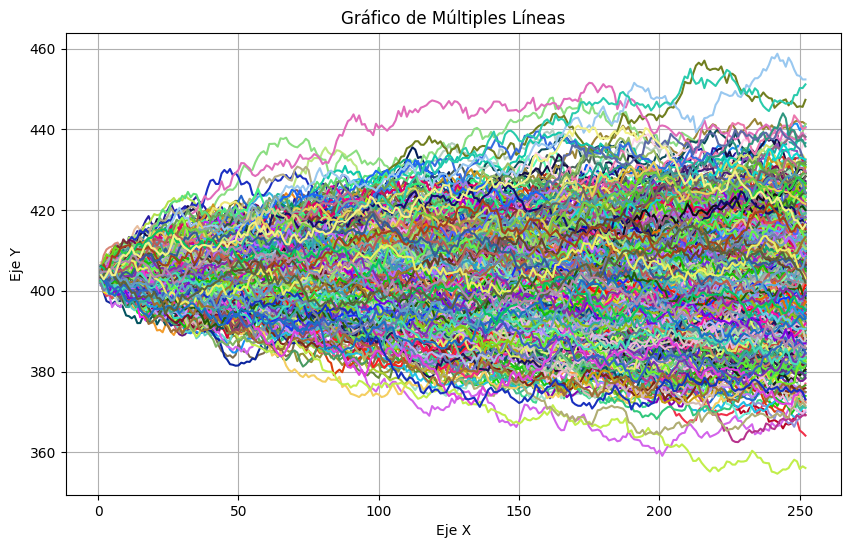

In [34]:
#Graficamos
lineas_multiples(monte_carlo_data, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y')

In [44]:
#Calculamos la probabilidad de perder 5% de la inversion inicial en el próximo año
# Obtenemos el último precio de cierre ajustado
s0 = data['Close'].iloc[-1]

# Si s0 es una Serie, extraemos el valor numérico
if isinstance(s0, pd.Series):
    s0 = s0.iloc[0]

# Mostramos el precio de compra sin el formato de Pandas
print('El precio de compra es:', round(s0, 2))

El precio de compra es: 403.84


In [64]:
# Extraer solo los valores numéricos de las últimas filas
precios = monte_carlo_data.tail().applymap(lambda x: float(str(x).split()[2]))

# Mostrar los precios sin etiquetas
display(precios.tail())


<ipython-input-64-82be4da99c2d>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  precios = monte_carlo_data.tail().applymap(lambda x: float(str(x).split()[2]))


,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
247,411.236844,400.471537,383.210600,373.449390,413.287823,418.496254,378.060419,414.496106,394.425882,414.984714,...,414.980659,385.986456,406.709457,408.963480,391.915117,403.436304,398.577963,406.514744,385.546377,417.571942
248,411.404844,398.360956,383.368389,373.117434,413.503593,418.406813,377.184012,414.910578,393.827018,414.649443,...,416.356879,387.840001,406.542225,406.630582,392.976912,405.205564,397.020136,405.334391,386.313592,417.457803
249,412.431932,398.854827,384.749762,372.865213,413.889588,417.817303,376.205299,414.732033,392.970084,415.308147,...,415.479298,387.575738,407.497121,404.913788,393.856734,405.364186,396.090958,405.059442,386.774653,416.423821
250,410.482787,399.876762,385.133393,374.430208,411.418356,417.563428,375.758699,413.513782,393.841406,416.147484,...,416.523658,386.649189,406.082973,404.299205,393.051225,405.800069,396.074781,403.886091,386.141477,415.270912
251,409.266562,400.634171,383.714258,373.938478,409.546243,416.746496,374.891846,414.406559,393.967198,414.760554,...,415.328741,384.552764,405.934282,403.210759,392.999386,408.081339,395.116350,402.018637,385.826557,416.393693


In [65]:
# Extraer solo los valores numéricos eliminando columnas no deseadas
precios_cierre = monte_carlo_data.iloc[-1, :].astype(float)

# Mostrar en formato limpio
print(precios_cierre.to_string(index=True, header=False))

sim_0      409.266562
sim_1      400.634171
sim_2      383.714258
sim_3      373.938478
sim_4      409.546243
sim_5      416.746496
sim_6      374.891846
sim_7      414.406559
sim_8      393.967198
sim_9      414.760554
sim_10     399.012155
sim_11     414.321711
sim_12     396.149139
sim_13     409.327392
sim_14     401.781021
sim_15     398.818222
sim_16     413.718215
sim_17     412.688972
sim_18     364.115905
sim_19     412.765158
sim_20     400.098712
sim_21     384.576437
sim_22     381.863108
sim_23     369.224943
sim_24     404.771845
sim_25     413.261987
sim_26     413.026562
sim_27     398.528430
sim_28     408.921502
sim_29     408.771266
sim_30     414.542938
sim_31     409.485228
sim_32     428.708512
sim_33     400.727983
sim_34     387.743727
sim_35     373.919970
sim_36     392.578028
sim_37     397.367172
sim_38     388.065964
sim_39     399.170156
sim_40     402.605124
sim_41     401.308000
sim_42     384.248451
sim_43     402.389820
sim_44     419.465537
sim_45    

<ipython-input-65-72a37d41bce8>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  precios_cierre = monte_carlo_data.iloc[-1, :].astype(float)


In [67]:
total = len(precios_cierre)
exito = (precios_cierre < (s0 * 0.95)).sum()

p = exito / total  # Probabilidad

print(f'Probabilidad de perder al menos 5%: {p*100:.2f}%')

Probabilidad de perder al menos 5%: 11.20%


In [72]:
# Precio inicial
s0 = data['Close'].iloc[-1]

# Si s0 es una Serie, extraemos el valor numérico
if isinstance(s0, pd.Series):
    s0 = s0.iloc[0]

# Mostramos el precio de compra sin el formato de Pandas
print('El precio de compra es:', round(s0, 2))

total = len(precios_cierre)

# la inversión cae más del 10%
perdida_10 = (precios_cierre < (s0 * 0.90)).sum()

# sube más del 10%
ganancia_10 = (precios_cierre > (s0 * 1.10)).sum()


p_perdida = perdida_10 / total
p_ganancia = ganancia_10 / total

# Mostrar resultados
print(f'Probabilidad de perder al menos 10%: {p_perdida * 100:.2f}%')
print(f'Probabilidad de ganar al menos 10%: {p_ganancia * 100:.2f}%')

El precio de compra es: 403.84
Probabilidad de perder al menos 10%: 0.20%
Probabilidad de ganar al menos 10%: 0.60%


In [73]:
print(f'Mínimo precio final: {precios_cierre.min()}')
print(f'Máximo precio final: {precios_cierre.max()}')

Mínimo precio final: 356.09348047998753
Máximo precio final: 452.3690337245121
